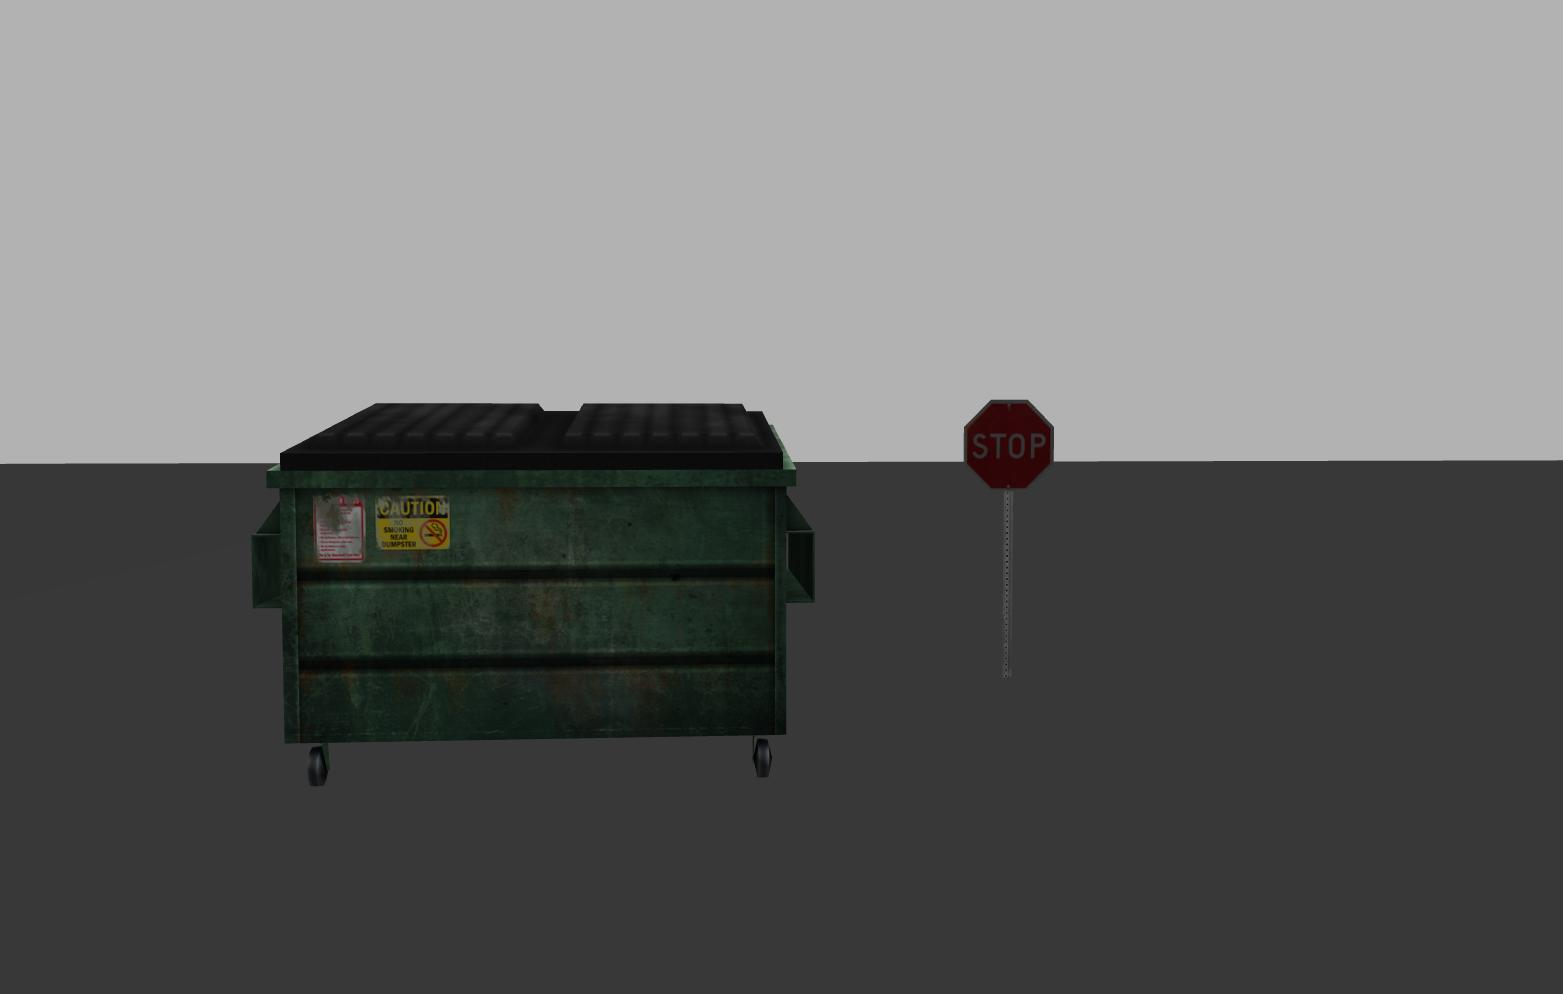

In [5]:
import torch
from PIL import Image
import cv2

image = cv2.imread("gazebo_set/images/train1.jpg")

# convert color from CV2 BGR back to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(image))

#Image.open('gazebo_set/images/train1.jpg')

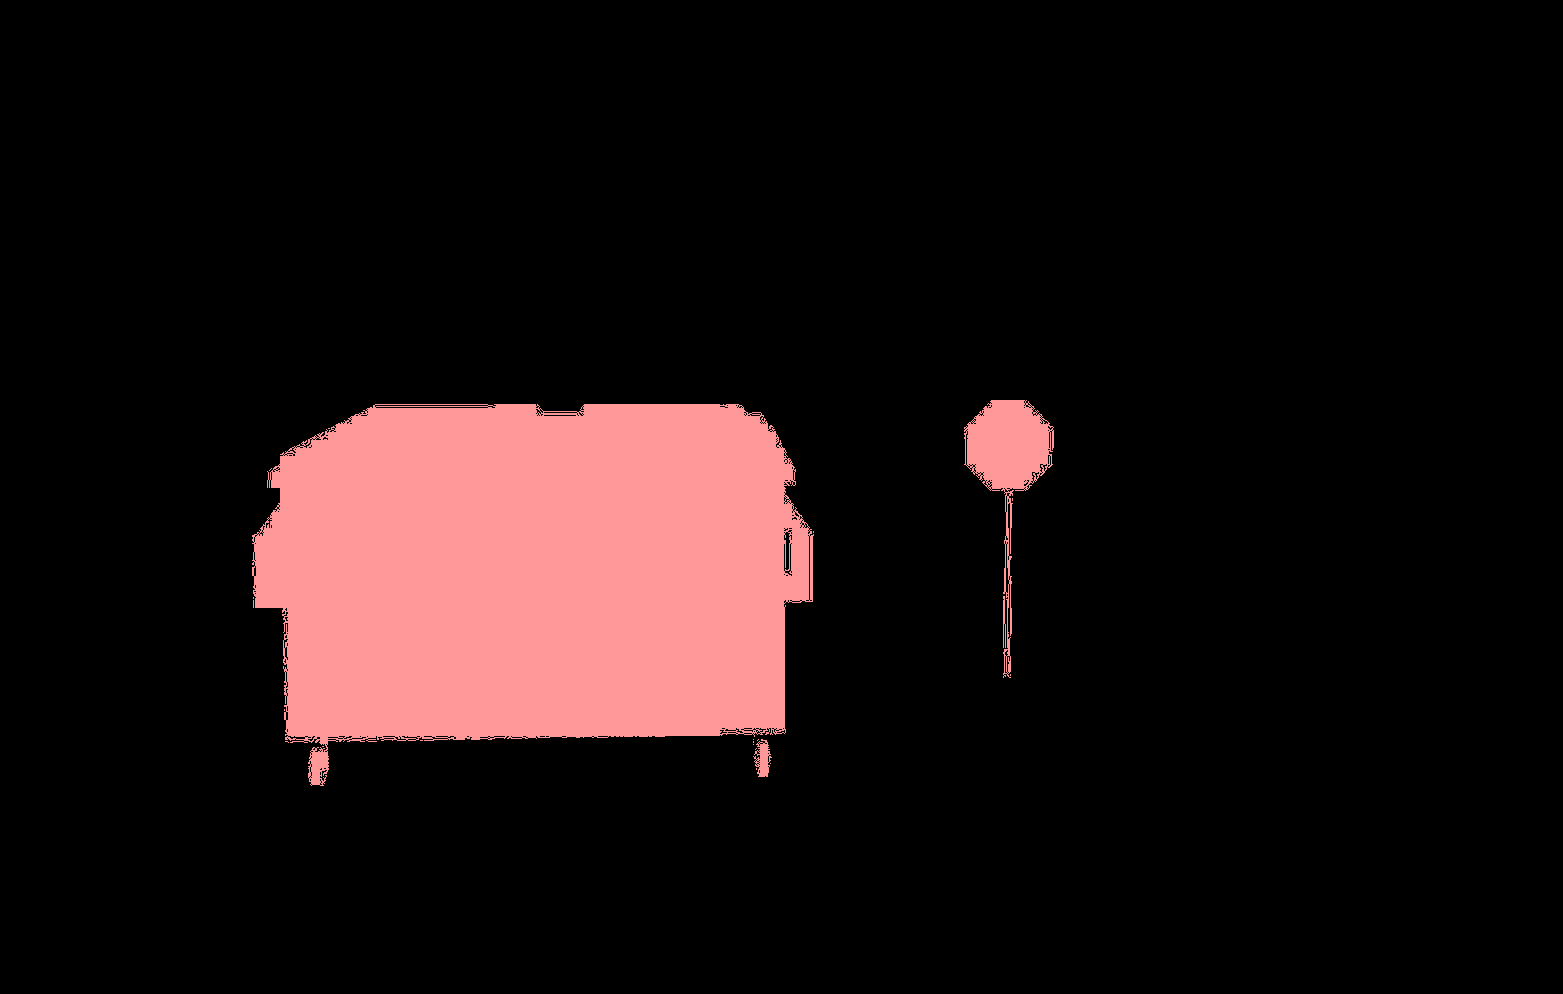

In [54]:
mask = Image.open('gazebo_set/masks/train1_mask.jpg').convert('L')
mask = np.array(mask)

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i][j] == 255:
            mask[i][j] = 1
        else:
            mask[i][j] = 0

mask = Image.fromarray(np.uint8(mask))
mask.save("gazebo_set/masks/" + "train1_mask_edit", "JPEG")
mask.show()

mask.putpalette([
    0, 0, 0, # Affects background (rgb for pixels with (0,0,0))
    255, 153, 153, # (1,1,1)
    255, 255, 0, # (2,2,2)
    255, 153, 0, # (3,3,3)
])
mask

# You would do this if you set each object in your figure to (0,0,0), (1,1,1), etc
# For my training data I have set everything to white, so this is not needed

In [59]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

# Creating a class to store our dataset and access it easier later
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root # Root directory to find images
        self.transforms = transforms #Stores transformed images for data augmentation
        # Store all image file paths, sorting them to ensure they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks/edit"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks/edit", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # Mask not converted to RGB as each colour corresponds to a different object.
        # with 0 being bg
        # Mask is in "L" mode (greyscale)
        mask = Image.open(mask_path)
        
        mask = np.array(mask)
        # Get all unique object ids (if there are three objects => [0,1,2])
        obj_ids = np.unique(mask)
        print("obj_ids: ", obj_ids)
        # Remove first id which is the background
        obj_ids = obj_ids[1:]

        # Split the color-encoded mask into a set of binary masks
        # Still need to figure how this works exactly
        masks = mask == obj_ids[:, None, None]
        print("Masks: ", masks)

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        print("Num_objs: ", num_objs)
        boxes = []
        for i in range(num_objs):
            # Not sure how numpy where works
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        
        # Saving bounding box coordinates in pytorch tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # There is only one class (person), change if more objects are shown in scene
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])

        # Computing area of all bounding boxes
        area = (boxes[:,3] - boxes[:, 1]) * (boxes[:,2] - boxes[:,0])
        
        # Supposed all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Creating dictionary to store info about target
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [60]:
dataset = Dataset('gazebo_set')
dataset[0]

obj_ids:  [0 1]
Masks:  [[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
Num_objs:  1


(<PIL.Image.Image image mode=RGB size=1563x994 at 0x2AA8809A9A0>,
 {'boxes': tensor([[ 256.,  400., 1047.,  783.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([302953.]),
  'iscrowd': tensor([0])})

In [8]:
# Fintuning from a pretrained model

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one, that has num_clsses which is user-defined
num_classes = 2 # 1 class (person) + background
# Get number of input features the classifier uses
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# Modifying the model to add a different backbone
# Most probably what I'll be using

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Load a pre-trained for classification and return only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of output channels in a backbone.
# For mobilenet_v2, it's 1280, so we add it below
backbone.out_channels = 1280

# Let's make the RPN generate 5 x 3 anchors per spatial location
# with 5 different sizes and 3 differen aspect ratios.
# We have a Tuple[Tuple[int]] because each features map could potentially
# have different sizes and aspect ratios
# More info here: https://medium.com/swlh/object-detection-with-deep-learning-rcnn-anchors-non-maximum-suppression-ce5a83c7c62b
anchor_generator = AnchorGenerator(sizes=((32, 64, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))

# Lets define what are the feature maps that we will use to perform the RoI cropping
# as well as the size of the crop after rescaling
# If your backbone returns a Tensor, featmap_names is expeted to be [0].
# More generally, the backbone should return an OrderedDict[Tensor], 
# and in featmap_names you can choose which feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# Put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                    num_classes=2,
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)

In [73]:
def get_instance_segmentation_model(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # And replace the mask predicitor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)

    return model

In [74]:
# Let's write some helper functions for data augmentation / transformation,
# which leverages the functions in refereces/detection that we have just copied

from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # Converts the image, a PIL image, into a PyTorch Tensor
    # I would need to edit this transforms file to support cv images
    transforms.append(T.ToTensor())
    if train:
        # During training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [75]:
# Use our dataset and defined transformations
dataset = Dataset('gazebo_set', get_transform(train=True))
dataset_test = Dataset('gazebo_set', get_transform(train=False))

# Split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
# Choosing all random indices except the last 50
dataset = torch.utils.data.Subset(dataset, indices[:-1])
# Last 50 indices used for testing/evaluating
dataset_test = torch.utils.data.Subset(dataset_test, indices[-1:])

# Define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [77]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Now let's instantiate the model and the optimizer
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Our dataset has two classes only - background and person
num_classes = 2

# Get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# Move model to the right device
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# And a learning arte scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [78]:
# Let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

e Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
obj_ids:  [0 1]
Masks:  [[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
Num_objs:  1
Epoch: [5]  [0/1]  eta: 0:00:00  lr: 0.000500  loss: 1.7686 (1.7686)  loss_classifier: 0.6147 (0.6147)  loss_box_reg: 0.0151 (0.0151)  loss_mask: 0.4561 (0.4561)  loss_objectness: 0.6812 (0.6812)  loss_rpn_box_reg: 0

In [83]:
# Pick on image from the test set
img, _ = dataset_test[0]
# Putting model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

obj_ids:  [0 1]
Masks:  [[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
Num_objs:  1


In [84]:
prediction

[{'boxes': tensor([[ 849.5539,  286.5419, 1302.8899,  512.3674],
          [ 578.5236,  603.0097, 1026.6787,  829.4198],
          [ 339.4111,  445.1362,  782.6398,  669.7228],
          [ 809.4005,  448.1770, 1258.7592,  674.1298],
          [ 811.3981,  368.9053, 1259.4541,  593.4921],
          [ 214.0467,  406.0940,  660.1032,  628.4781],
          [ 722.8719,  209.9704,  942.5462,  663.4292],
          [ 497.9701,  685.1573,  947.6457,  909.5334],
          [ 356.7659,  598.3990,  673.0175,  913.6375],
          [  97.8800,  685.9683,  549.6999,  912.1433],
          [   0.0000,  540.5905,  689.0616,  986.9717],
          [ 397.1921,  215.7321, 1029.4513,  849.9152],
          [ 538.4683,  328.4703,  984.4352,  555.3222],
          [ 243.7124,  176.0998,  470.0946,  622.6284],
          [ 217.6260,  525.7784,  657.7799,  751.5629],
          [  38.1479,  391.4434,  921.5618,  838.8363],
          [ 565.5876,  212.5438,  790.5143,  665.0309],
          [ 128.9905,  325.7346,  580.5

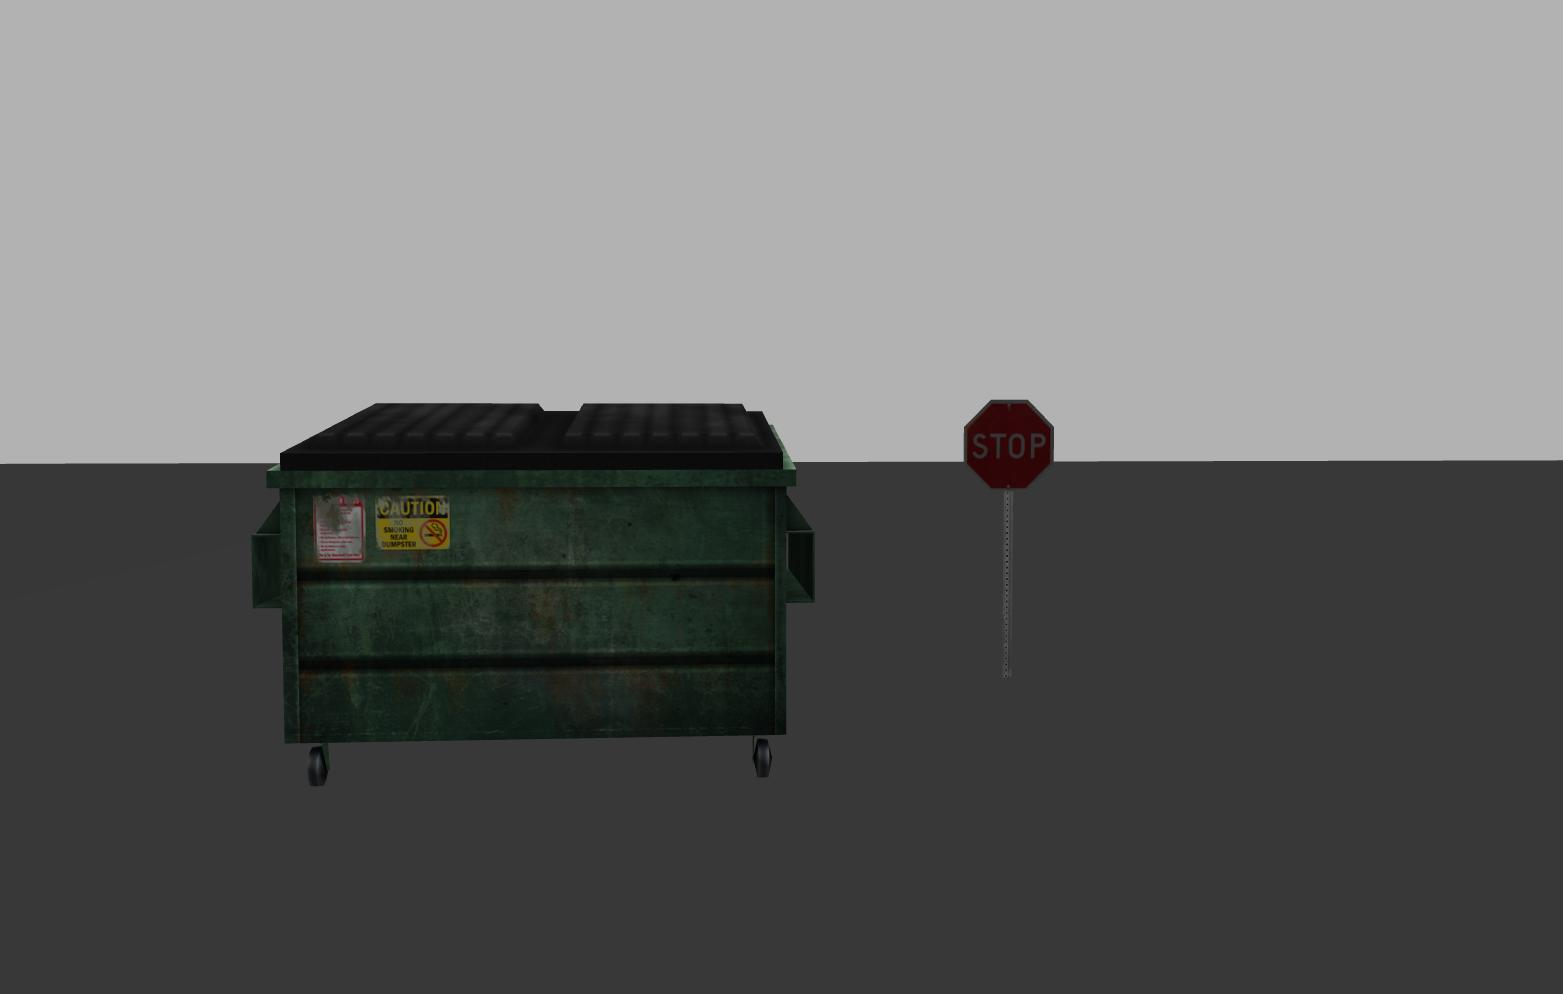

In [85]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

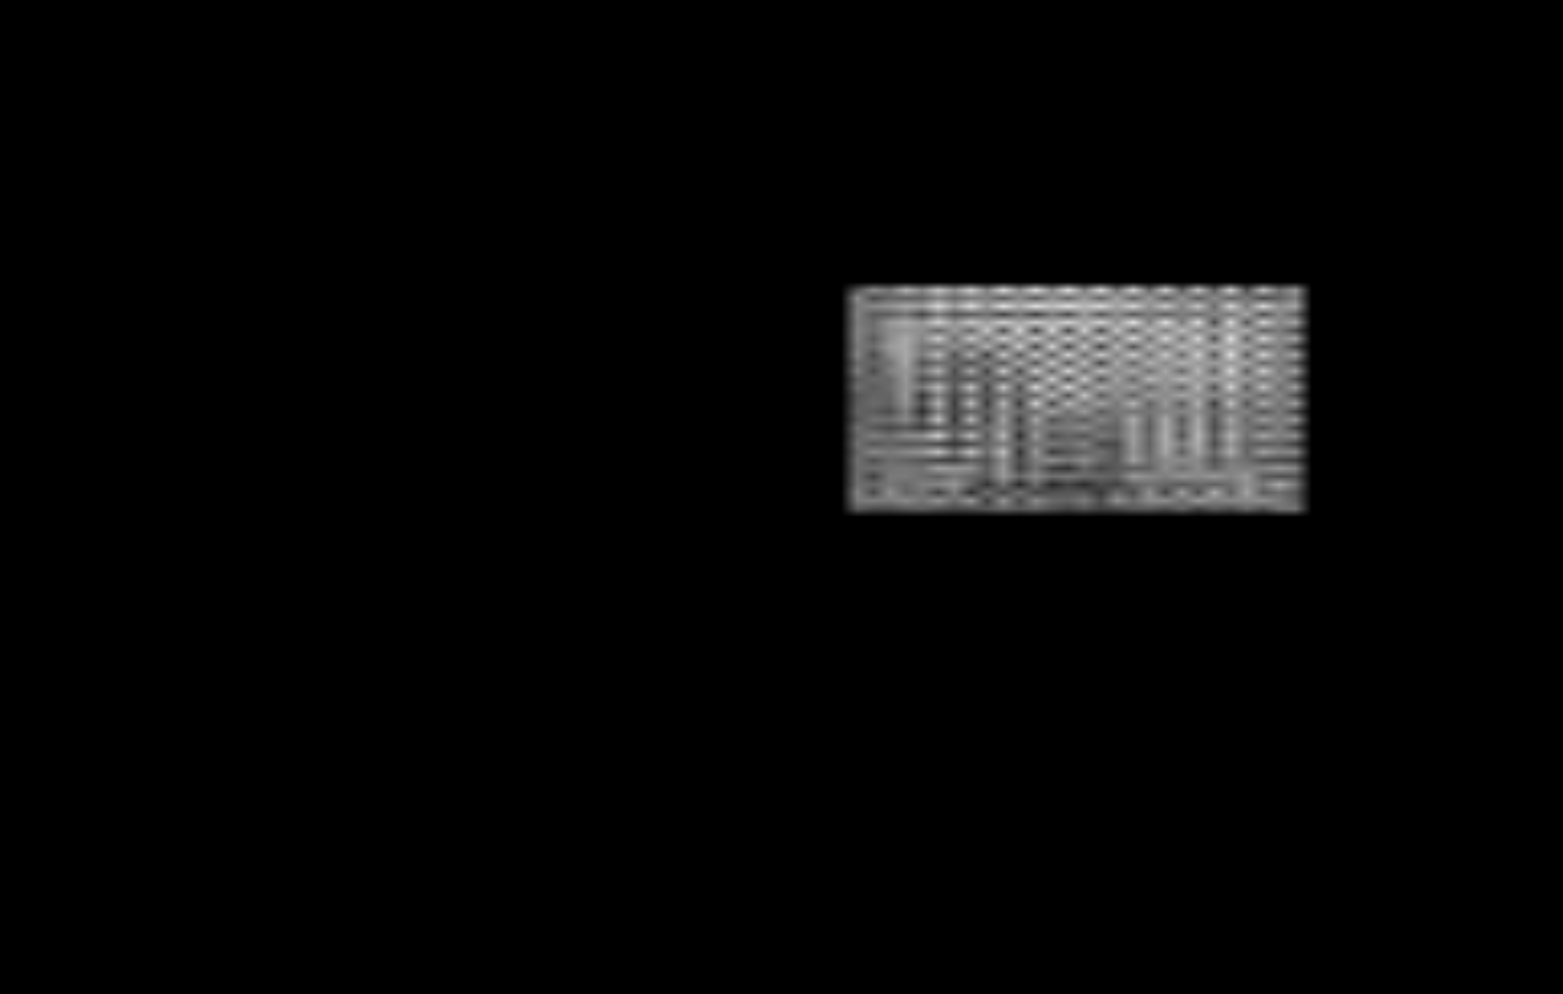

In [86]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())